In [ ]:
!pip install timm torch torchvision matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Unzip the file to the local Colab runtime for fast access
zip_path = '/content/drive/MyDrive/eye_dataset.zip' # or your Drive path
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# 2. Define your ViT Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Load the dataset using ImageFolder
train_dataset = datasets.ImageFolder(root='/content/data/dataset', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Loaded {len(train_dataset)} images in {len(train_dataset.classes)} classes.")

Loaded 4217 images in 4 classes.


In [ ]:
import torch
from torch.utils.data import random_split

# Calculate the sizes for the split
dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset randomly
# We use a manual_seed for reproducibility, ensuring we get the same split every time
generator = torch.Generator().manual_seed(42)
train_subset, val_subset = random_split(train_dataset, [train_size, val_size], generator=generator)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")

Training samples: 3373
Validation samples: 844


In [ ]:
from torch.utils.data import DataLoader

# Create DataLoaders
# We shuffle the training data to prevent the model from learning the order of images
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

# Check the first batch
images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}") # Expecting [32, 3, 224, 224]

Batch image shape: torch.Size([32, 3, 224, 224])


In [ ]:
import timm
import torch.nn as nn

# Create the model
# pretrained=True downloads the weights that help the model learn faster
# num_classes=4 sets the final layer to match your 4 disease categories
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=4)

# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Model initialized and moved to {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model initialized and moved to cuda


In [ ]:
import torch.optim as optim

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer - using a small learning rate (1e-4) is safer for fine-tuning
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

In [ ]:
import torch
import time
import copy

# 1. Training Parameters
num_epochs = 40
best_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Path to save the best model on your Google Drive
best_model_path = '/content/drive/MyDrive/best_eye_vit_model.pth'

print(f"Starting Training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    epoch_start = time.time()

    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # Zero the gradients

        outputs = model(images)
        _, preds = torch.max(outputs, 1) # Get predictions
        loss = criterion(outputs, labels)

        loss.backward() # Backpropagation
        optimizer.step() # Update weights

        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_subset)
    epoch_acc = running_corrects.double() / len(train_subset)

    # --- VALIDATION PHASE ---
    model.eval() # Set to evaluation mode
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad(): # Disable gradient tracking
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_loss / len(val_subset)
    val_epoch_acc = val_corrects.double() / len(val_subset)

    # Save metrics for plotting
    train_losses.append(epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accs.append(epoch_acc.item())
    val_accs.append(val_epoch_acc.item())

    # --- SAVE BEST MODEL ---
    # Only save if this epoch's accuracy is higher than previous best
    if val_epoch_acc > best_acc:
        best_acc = val_epoch_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"--> Best Model Saved (Acc: {best_acc:.4f})")

    duration = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f} | "
          f"Time: {duration:.0f}s")

print(f"Training Complete! Highest Validation Accuracy: {best_acc:.4f}")

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# 1. ENHANCED Preprocessing (Training only)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5), # Standard for fundus medical images
    transforms.RandomRotation(15), # Retinal images are rotationally invariant
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Simulates camera variation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. VALIDATION Preprocessing (Standard)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Create split-aware datasets
base_path = '/content/data/dataset'
full_train_ds = datasets.ImageFolder(root=base_path, transform=train_transform)
full_val_ds = datasets.ImageFolder(root=base_path, transform=val_transform)

# Ensure same indices are used as the baseline for a fair comparison
indices = list(range(len(full_train_ds)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_loader = DataLoader(Subset(full_train_ds, train_idx), batch_size=32, shuffle=True)
val_loader = DataLoader(Subset(full_val_ds, val_idx), batch_size=32, shuffle=False)

In [ ]:
import torch
import time

# Metrics storage for thesis plotting
history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("Starting Training with Loss Tracking...")

for epoch in range(40):
    epoch_start = time.time()

    # --- 1. TRAINING PHASE ---
    enhanced_model.train()
    running_train_loss = 0.0
    running_train_corrects = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = enhanced_model(images)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0)
        running_train_corrects += torch.sum(preds == labels.data)

    # Update Learning Rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Calculate average train metrics
    epoch_train_loss = running_train_loss / len(train_subset)
    epoch_train_acc = running_train_corrects.double() / len(train_subset)

    # --- 2. VALIDATION PHASE ---
    enhanced_model.eval()
    running_val_loss = 0.0
    running_val_corrects = 0

    with torch.no_grad(): # Disable gradient calculation for speed/memory
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = enhanced_model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            running_val_loss += loss.item() * images.size(0)
            running_val_corrects += torch.sum(preds == labels.data)

    # Calculate average validation metrics
    epoch_val_loss = running_val_loss / len(val_subset)
    epoch_val_acc = running_val_corrects.double() / len(val_subset)

    # Save metrics to history
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_acc'].append(epoch_train_acc.item())
    history['val_acc'].append(epoch_val_acc.item())

    # --- 3. PRINT RESULTS ---
    duration = time.time() - epoch_start
    print(f"Epoch {epoch+1}/40 | LR: {current_lr:.6f}")
    print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}")
    print(f"Val Loss:   {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    print(f"Time: {duration:.0f}s | --------------------------------")

    # Save best model logic
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(enhanced_model.state_dict(), '/content/drive/MyDrive/best_enhanced_vit.pth')
        print(f"--> Best Model Saved! (Val Acc: {best_acc:.4f})")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Re-run your unzipping and DataLoader setup here
# (Make sure 'val_loader' is ready)

Mounted at /content/drive


In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

# Unzip the dataset to the local runtime for speed
zip_path = '/content/drive/MyDrive/eye_dataset.zip'
extract_path = '/content/data'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset extracted successfully.")
else:
    print("✅ Dataset already extracted.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset extracted successfully.


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Standard normalization for ViT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# The folder structure is usually /content/data/dataset/Normal, etc.
# Check your path if this throws an error.
data_path = '/content/data/dataset'
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Re-split to get the 20% validation set
indices = list(range(len(full_dataset)))
_, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

val_subset = Subset(full_dataset, val_idx)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Define classes for the report
class_names = full_dataset.classes # ['Cataract', 'Diabetic_Retinopathy', 'Glaucoma', 'Normal']
print(f"✅ val_loader ready with {len(val_subset)} images.")

✅ val_loader ready with 844 images.


🔍 Evaluating V1...
🔍 Evaluating V2...
🔍 Evaluating V3...


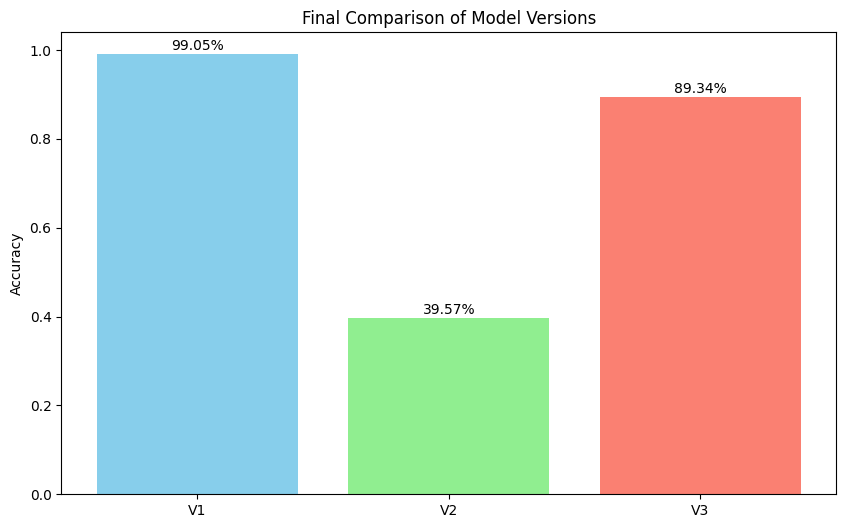

In [ ]:
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss()

model_paths = {
    "V1": "/content/drive/MyDrive/best_eye_vit_model.pth",
    "V2": "/content/drive/MyDrive/enhanced_eye_vit.pth",
    "V3": "/content/drive/MyDrive/best_enhanced_vit.pth"
}

results = {}

for name, path in model_paths.items():
    if not os.path.exists(path):
        print(f"⚠️ Skipping {name}: File not found.")
        continue

    print(f"🔍 Evaluating {name}...")
    model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4).to(device)

    # Load weights safely
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * images.size(0)
            val_corrects += torch.sum(preds == labels.data)

    results[name] = {
        "loss": val_loss / len(val_subset),
        "acc": val_corrects.double().item() / len(val_subset)
    }

# Plot the results
if results:
    names = list(results.keys())
    accs = [results[n]['acc'] for n in names]

    plt.figure(figsize=(10, 6))
    plt.bar(names, accs, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel('Accuracy')
    plt.title('Final Comparison of Model Versions')
    for i, v in enumerate(accs):
        plt.text(i, v + 0.01, f"{v:.2%}", ha='center')
    plt.show()

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import torch
import timm
import os

# 1. Setup the plot area for 3 confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Use full_dataset since that is what we defined in the loading step
classes = full_dataset.classes

for i, (name, path) in enumerate(model_paths.items()):
    if not os.path.exists(path):
        print(f"Skipping {name}: path not found.")
        continue

    print(f"📊 Generating Confusion Matrix for {name}...")

    # Initialize and Load model
    model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=4).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()

    y_true = []
    y_pred = []

    # Collect predictions from the val_loader
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # 2. Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # 3. Plot Heatmap on the specific subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=classes, yticklabels=classes, cbar=False)
    axes[i].set_title(f"Confusion Matrix: {name}")
    axes[i].set_ylabel('Actual')
    axes[i].set_xlabel('Predicted')

    # Print text report for detailed thesis metrics
    print(f"\n--- {name} Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=classes))

plt.tight_layout()
plt.show()

📊 Generating Confusion Matrix for V1...

--- V1 Classification Report ---
                      precision    recall  f1-score   support

            cataract       0.98      0.99      0.99       233
diabetic_retinopathy       1.00      1.00      1.00       224
            glaucoma       0.99      0.97      0.98       188
              normal       0.99      0.99      0.99       199

            accuracy                           0.99       844
           macro avg       0.99      0.99      0.99       844
        weighted avg       0.99      0.99      0.99       844

📊 Generating Confusion Matrix for V2...

--- V2 Classification Report ---
                      precision    recall  f1-score   support

            cataract       0.45      0.72      0.55       233
diabetic_retinopathy       0.36      0.72      0.48       224
            glaucoma       0.20      0.01      0.02       188
              normal       0.21      0.02      0.03       199

            accuracy                     